# Tool 2 - Microgrid sizing

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from datetime import timedelta
import random
import seaborn as sns
sns.set()

## Data viewing

In [2]:
#Import one week of data to look at the variation of demand price and generation. 

In [3]:
df_demand = pd.read_csv('Super Parc Veolia data.csv', header=[0], index_col=[0],nrows=24*7)
df_demand = df_demand.iloc[::1,:] # selects data with hourly frequency

df_price = pd.read_csv('Energy prices.csv', header=[0], index_col=[0],nrows=48*7)
df_price = df_price.iloc[::2,:] # selects data with hourly frequency

df_generation = pd.read_csv('Solar UK.csv', header=[0], index_col=[0],nrows=24*7)
df_generation = df_generation.iloc[::1,:] # selects data with hourly frequency

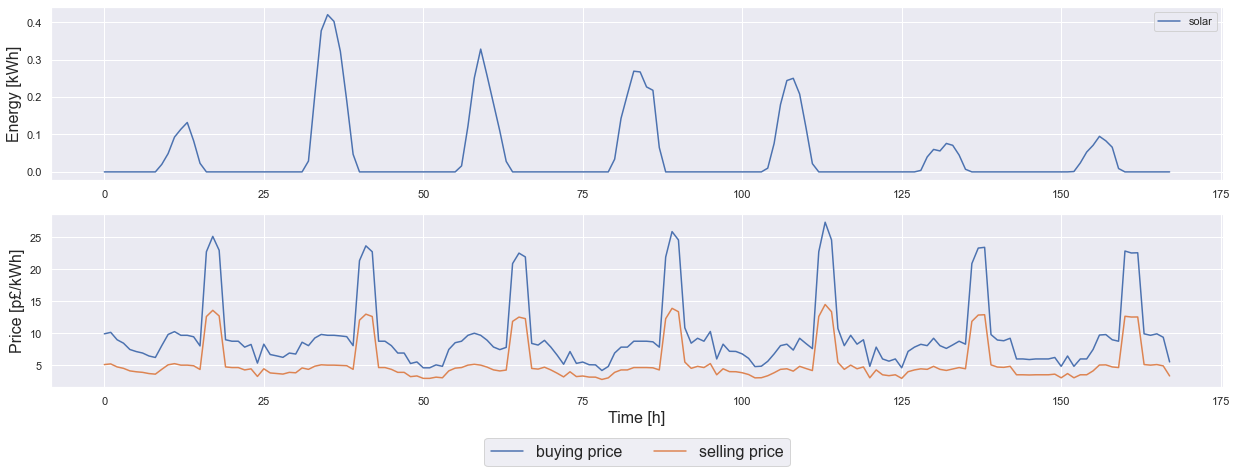

In [4]:
### Plot generation and demand, power grid prices
electricity_demand = df_demand['Electricity (kWh)'].values
heat_demand= df_demand.drop(['Electricity (kWh)','Time','Cooling (kWh)'],axis=1).sum(numeric_only=True,axis=1).values
cooling_demand=df_demand.drop(['Electricity (kWh)','Time','Steam (kWh)','LTHW (kWh)'],axis=1).sum(numeric_only=True,axis=1).values
solar_generation= df_generation['Solar generation'].values
buying_price=df_price['Electricity Buying'].values
selling_price=df_price['Electricity Selling'].values
fig,ax = plt.subplots(2,1,figsize=(21,7))

ax[0].plot(solar_generation,label='solar')
ax[1].plot(df_price['Electricity Buying'].values, label='buying price')
ax[1].plot(df_price['Electricity Selling'].values, label='selling price')

# set axes labels
plt.xlabel('Time [h]',fontsize=16)
ax[0].set_ylabel('Energy [kWh]',fontsize=16)
ax[1].set_ylabel('Price [p£/kWh]',fontsize=16)
# legend and grid
ax[0].legend()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.5),fontsize=16)
for i in range(2):
    ax[i].grid(b = True)
plt.show()

## Importing data 

In [5]:
#Importing one year of demand, price and solar generation data

df_demand = pd.read_csv('Super Parc Veolia data.csv')
df_demand = df_demand.iloc[::1,:] # selects data with hourly frequency

df_price = pd.read_csv('Energy prices.csv', header=[0], index_col=[0],nrows=24*365)
df_price = df_price.iloc[::1,:] # selects data with hourly frequency

df_generation = pd.read_csv('Solar UK.csv', header=[0], index_col=[0],nrows=24*365)
df_generation = df_generation.iloc[::1,:] # selects data with hourly frequency


### Technology definition 

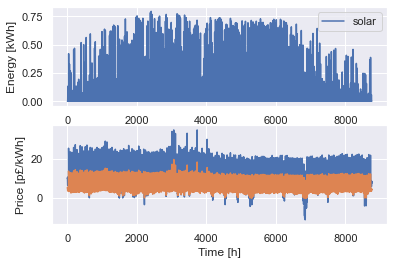

In [6]:
### Plot generation and demand, power grid prices
electricity_demand = df_demand['Electricity (kWh)'].values
heat_demand= df_demand.drop(['Electricity (kWh)','Time','Cooling (kWh)'],axis=1).sum(numeric_only=True,axis=1).values
cooling_demand=df_demand.drop(['Electricity (kWh)','Time','Steam (kWh)','LTHW (kWh)'],axis=1).sum(numeric_only=True,axis=1).values
solar_generation= df_generation['Solar generation'].values
buying_price=df_price['Electricity Buying'].values
selling_price=df_price['Electricity Selling'].values
fig,ax = plt.subplots(2,1)
#ax[0].plot(electricity_demand,'r--',label='demand')
ax[0].plot(solar_generation,label='solar')
ax[1].plot(df_price['Electricity Buying'].values, label='buying price')
ax[1].plot(df_price['Electricity Selling'].values, label='selling price')

# set axes labels
plt.xlabel('Time [h]')
ax[0].set_ylabel('Energy [kWh]')
ax[1].set_ylabel('Price [p£/kWh]')
# legend and grid
ax[0].legend()
for i in range(2):
    ax[i].grid(b = True)
plt.show()

In [7]:
#Solar
lt_solar=25 #years
#Cost
capex_solar=50 #USD/kW #
opex_solar=18 #USD/kW/year #(p.68/ Commercial non utility scale total installed PV cost
#CO2
co2_solar=40 #gCO2/kWh

In [8]:
#Biogas turbine 
# Sources : https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/961322/Part_5_CHP_Finance_BEIS_v03.pdf
elec_eff = 0.33 # electricity efficiency 
heat_eff = 0.43 # heat efficiency of CHP
lt_chp=20
#Cost
capex_chp=971 #USD/kW 
opex_chp=5 #USD/kWh/year
#CO2
co2_chp=80 #gCO2/kWh
biogas_fuel= 5 #pUSD/kWh #https://www.oxfordenergy.org/wpcms/wp-content/uploads/2017/06/Biogas-A-significant-contribution-to-decarbonising-gas-markets.pdf

In [9]:
#Grid
buying_price= 1.39*df_price['Electricity Buying'].values #pUSD/kWh. The prices being in pounds, the 1.39 value 
selling_price= 1.39*df_price['Electricity Selling'].values

co2_grid=181 #gCO2/kWh Country 2020 electricity grid intensity
co2_price=0.007 #pUSD/gCO2 

## Isolating the maximum consumption day 

In [10]:
#These functions will be used to define the maximum consumption day
# It is defined as the day where the difference between the electricity generated by the CHP and the electricity demand is the most important

def max_consumption_day(electricity_demand, heat_demand):
    n=electricity_demand.shape[0]
    l=[]
    l2=[]
    j=0
    while j<n:
        s=0
        for k in range (24):
            s+=electricity_demand.values[k+j]-elec_eff/heat_eff*heat_demand.values[k+j]
        l.append(s)
        j+=24
    max_value=max(l)
    
    return l.index(max_value)
def max_consumption(electricity_demand, heat_demand):
    n=electricity_demand.shape[0]
    l=[]
    l2=[]
    j=0
    while j<n:
        s=0
        for k in range (24):
            s+=electricity_demand[k+j]-elec_eff/heat_eff*heat_demand[k+j]
        l.append(s)
        j+=24
    
    
    return (l)

def max_difference_day(electricity_demand, heat_demand):
    n=electricity_demand.shape[0]
    l=[]
    for k in range (n):
        l.append(electricity_demand.values[k]-elec_eff/heat_eff*heat_demand.values[k])
    max_value=max(l)
    
    return int(l.index(max_value)/24)

def max_difference_value(electricity_demand, heat_demand):
    n=electricity_demand.shape[0]
    l=[]
    for k in range (n):
        l.append(electricity_demand.values[k]-elec_eff/heat_eff*heat_demand.values[k])
    max_value=max(l)
    
    return int(max_value)

In [11]:
#Find the day
day_max_consumption=max_difference_day(df_demand['Electricity (kWh)'],df_demand.drop(['Electricity (kWh)','Time','Cooling (kWh)'],axis=1).sum(numeric_only=True,axis=1))
day_max_difference=max_difference_day(df_demand['Electricity (kWh)'],df_demand.drop(['Electricity (kWh)','Time','Cooling (kWh)'],axis=1).sum(numeric_only=True,axis=1))
day_max_value=max_difference_value(df_demand['Electricity (kWh)'],df_demand.drop(['Electricity (kWh)','Time','Cooling (kWh)'],axis=1).sum(numeric_only=True,axis=1))

#Define new variables based on this maximum consumption day. 
#It is also possible to study a larger time period by changing the +1 in +2/+3..+10 to study a period of 1 day 2 days, 10 days around this maximum consumption day 
electricity_demand=electricity_demand[(day_max_consumption)*24:(day_max_consumption+1)*24]
heat_demand= heat_demand[(day_max_consumption)*24:(day_max_consumption+1)*24]
solar_generation=solar_generation[(day_max_consumption)*24:(day_max_consumption+1)*24]
buying_price= buying_price[(day_max_consumption)*24:(day_max_consumption+1)*24]
selling_price= selling_price[(day_max_consumption)*24:(day_max_consumption+1)*24]
cooling_demand= cooling_demand[(day_max_consumption)*24:(day_max_consumption+1)*24]
print(heat_demand)

[ 8282.323448 10095.53418   8562.050402 10200.118177  8609.254365
 10930.501162 11736.988743 12628.35721  12179.208798 10922.279798
 12191.98743  12410.776955 11438.192826  8386.033859  9450.869714
  9057.929045  8550.105503  8135.672228  9523.355495  8255.665891
  8443.894045 10927.709541 10473.681135 11428.307059]


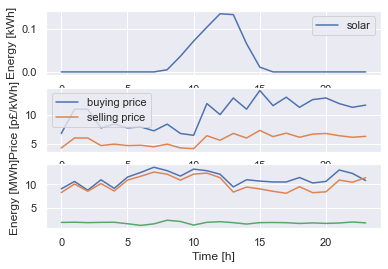

In [12]:
#Plotting of the consumption during this day 

fig,ax = plt.subplots(3,1)
#ax[0].plot(electricity_demand,'r--',label='demand')
#fig, ax = plt.subplots(figsize = (8,4))
ax[0].plot(solar_generation,label='solar')
ax[1].plot(buying_price, label='buying price')
ax[1].plot(selling_price, label='selling price')
ax[2].plot(electricity_demand/1000, label='Electricity_demand')
ax[2].plot(heat_demand/1000, label='Industrial heat demand')
ax[2].plot(cooling_demand/1000, label='Coolingdemand')
# set axes labels
plt.xlabel('Time [h]')
ax[0].set_ylabel('Energy [kWh]')
ax[1].set_ylabel('Price [p£/kWh]')
ax[2].set_ylabel('Energy [MWh]')
# legend and grid
ax[0].legend()
ax[1].legend()
#ax[2].legend()
for i in range(3):
    ax[i].grid(b = True)

plt.show()

## Microgrid sizing 

### PV - CHP - Grid

In [13]:
#PV
X_max=int(day_max_value*6/1000) #Maximum PV value. We decided to multiply by 6 to have a wide range. It also possible to input one numerical value only
#X_max=50
#Timeframe
n_periods=electricity_demand.shape[0]
print(n_periods)

24


In [14]:
#Definition of the optimization problem

# Variable and Constant definition
import picos as pic # to use picos modelling library (docs on https://picos-api.gitlab.io/picos/)

prob = pic.Problem() # initialises problem object

# energy exchange variables
P_deg = pic.RealVariable('P_deg',n_periods) # from grid to demand [kWh]
# decision variable to redirect solar generation and CHP generation
P_gde = pic.RealVariable('P_gde',n_periods) # from demand to grid 

# Sizing Variables
S=pic.RealVariable ('S')
p = pic.Constant('pr',buying_price) # [USD/kWh]
p_sell = pic.Constant('pr_s',selling_price) # [USD/kWh]
de = pic.Constant('electricity demand',electricity_demand/1000) # [MWh]
he = pic.Constant('heat demand',heat_demand/1000) # [MWh]
sol = pic.Constant('sol',solar_generation) # [kWh]

In [15]:
#Constraint definition
# Electricity: energy balance
prob.add_constraint(S*sol + (elec_eff/heat_eff)*he + P_deg + P_gde == de)
#Boundaries
prob.add_constraint(P_deg>=0)
prob.add_constraint(P_gde<=0)
prob.add_constraint(S <= X_max)
prob.add_constraint (S>=0)

<1×1 Affine Constraint: S ≥ 0>

In [16]:
#Problem solving
print(prob)
enrg_cost = (n_periods/24.0)*(1000*capex_solar*S/(365*lt_solar)+1000*S*opex_solar/365 + 1000*capex_chp*max(he)/(365*lt_chp) + 1000*sum(he)*opex_chp/365) +  sum(10*(p[t]+co2_grid*co2_price)*P_deg[t]+10*p_sell[t]*P_gde[t]+10*he[t]*(biogas_fuel/heat_eff + co2_chp*co2_price) + 10*S*sol[t]*co2_solar*co2_price  for t in range(n_periods))
prob.set_objective('min',enrg_cost)
solv = prob.solve(solver='cvxopt')

Linear Feasibility Problem
  find an assignment
  for
    1×1 real variable S
    24×1 real variable P_deg, P_gde
  subject to
    S·sol + 0.767442·heat demand + P_deg + P_gde = electricity demand
    P_deg ≥ 0
    P_gde ≤ 0
    S ≤ 28
    S ≥ 0


<ipython-input-16-188630111df1>:3: DeprecationWarning: Expression.__gt__ is deprecated: PICOS treats all inequalities as non-strict. Using the strict inequality comparison operators may lead to unexpected results when dealing with integer problems.
  enrg_cost = (n_periods/24.0)*(1000*capex_solar*S/(365*lt_solar)+1000*S*opex_solar/365 + 1000*capex_chp*max(he)/(365*lt_chp) + 1000*sum(he)*opex_chp/365) +  sum(10*(p[t]+co2_grid*co2_price)*P_deg[t]+10*p_sell[t]*P_gde[t]+10*he[t]*(biogas_fuel/heat_eff + co2_chp*co2_price) + 10*S*sol[t]*co2_solar*co2_price  for t in range(n_periods))


In [17]:
#Results presentation
total_elec = sum(electricity_demand) #kWh
total_heat = sum(heat_demand)
total_imports= sum(P_deg)
total_exports = sum(P_gde)
emissions=sum(1000*co2_grid*P_deg[t]+1000*he[t]/heat_eff*co2_chp + 1000*S*sol[t]*co2_solar  for t in range(n_periods))
energy_intensity=emissions/(total_elec+total_heat)
cost_kWh=enrg_cost.value/(total_elec+total_heat)
#Print the results
print('Completed. Status: ' + prob.status)
print ('S:',S, 'MW' )
print('Grid Share:',total_imports*1000/total_elec*100,'%')
print('Total imports:',total_imports,'MWh')
print('Max Charing/Discharging capacity',max(P_deg.value),'MWh')
print('Energy cost: '+str(enrg_cost.value),'USD')
print('Cost/kWh',cost_kWh,'USD')
print(energy_intensity)

Completed. Status: optimal
S: 23.106473787867618 MW
Grid Share: 26.32977159878344 %
Total imports: 71.20172530571472 MWh
Max Charing/Discharging capacity 4.684362669300434 MWh
Energy cost: 43947.98603240249 USD
Cost/kWh 0.08562791601695521 USD
114.13348076054989


### PV GRID CHP BATTERY 

In [18]:
# From the past sizing, we have a new value for the PV pannels upper boundary
Xmax=S.value

In [19]:
#Battery 
batt_power_rating = max(P_deg.value) #MW
batt_cap = total_imports/3 # MWh
batt_eff = 0.95 # storage charge/discharge efficiency
e_init = 0 # initial SoC of battery
lt_battery=12
#Cost
capex_battery=350 #USD/kWh Irena
opex_battery=5 #USD/kWh/year
#CO2
co2_batt=65000/(lt_battery*365) #gCO2/kWh 
print(batt_power_rating)
print(batt_cap)

4.684362669300434
23.733908435238238


In [20]:
#Problem definition

import picos as pic
prob2 = pic.Problem() # initialises problem object

# energy exchange variables
P_import = pic.RealVariable('P_import',n_periods) # importing energy from the grid
P_export = pic.RealVariable('P_export',n_periods) # exporting energy from the grid
#Flow of energy towards the battery 
P_solarde = pic.RealVariable('P_solarde',n_periods) 
P_solarba = pic.RealVariable('P_solarba',n_periods) 
P_chpde = pic.RealVariable('P_chpde',n_periods) 
P_chpba = pic.RealVariable('P_chpba',n_periods)
P_battde = pic.RealVariable('P_battde',n_periods) 
e = pic.RealVariable('e',n_periods)
# Sizing Variables
X = pic.RealVariable('X') 
p = pic.Constant('pr',buying_price) # [USD/kWh]
p_sell = pic.Constant('pr_s',selling_price) # [USD/kWh]
de = pic.Constant('electricity demand',electricity_demand/1000) # [MWh]
he = pic.Constant('heat demand',heat_demand/1000) # [MWh]
sol = pic.Constant('sol',solar_generation) # [kWh]



In [21]:
#Constraint definition
# Electricity: energy balance
prob2.add_constraint(P_chpde + P_solarde + batt_eff*P_battde + P_import + P_export  == de) 
prob2.add_constraint(P_chpde + P_chpba == (elec_eff/heat_eff)*he)
prob2.add_constraint(P_solarde + P_solarba  == X*sol )

#Boundaries
prob2.add_constraint(P_solarde>=0)
prob2.add_constraint(P_solarba>=0)
prob2.add_constraint(P_chpde>=0)
prob2.add_constraint(P_chpba>=0)
prob2.add_constraint(P_battde>=0)
prob2.add_constraint(P_import>=0)
prob2.add_constraint(P_export<=0)
prob2.add_constraint(X<=Xmax)
# storage capacity 
prob2.add_constraint(e <= 25)
prob2.add_constraint(0 <= e )
# integrator dynamics
prob2.add_constraint(e[0] == e_init + batt_eff*(P_solarba[0] + P_chpba[0]) - P_battde[0])
for t in range(1,n_periods):
    prob2.add_constraint(e[t] == e[t-1] + batt_eff*(P_solarba[t] + P_chpba[t]) - P_battde[t])

#Constraint on final SoC        
#prob2.add_constraint(e[n_periods-1] == e_init) 

#Storage definition 
# discharge
prob2.add_constraint(P_battde <= batt_power_rating) 
# charge
prob2.add_constraint(P_solarba + P_chpba <=  batt_power_rating)

<24×1 Affine Constraint: P_solarba + P_chpba ≤ [4.68436]>

In [22]:
#Problem solving
enrg_cost2 = (n_periods/24)*(1000*capex_solar*X/(365*lt_solar)+1000*X*opex_solar/365 + 1000*capex_chp*max(he)/(365*lt_chp)+1000*sum(he)*opex_chp/365 + 1000*max(e)*co2_batt*(n_periods/24)*co2_price + 1000*(capex_battery/lt_battery+opex_battery)*max(e)/365) +  sum(10*(p[t]+co2_grid*co2_price)*P_import[t]+10*p_sell[t]*P_export[t]+10*he[t]*(biogas_fuel/heat_eff + co2_chp*co2_price) + 10*X*sol[t]*co2_solar*co2_price  for t in range(n_periods))
prob2.set_objective('min',enrg_cost2)
solv = prob2.solve(solver='cvxopt')

<ipython-input-22-ed181969f506>:2: DeprecationWarning: Expression.__gt__ is deprecated: PICOS treats all inequalities as non-strict. Using the strict inequality comparison operators may lead to unexpected results when dealing with integer problems.
  enrg_cost2 = (n_periods/24)*(1000*capex_solar*X/(365*lt_solar)+1000*X*opex_solar/365 + 1000*capex_chp*max(he)/(365*lt_chp)+1000*sum(he)*opex_chp/365 + 1000*max(e)*co2_batt*(n_periods/24)*co2_price + 1000*(capex_battery/lt_battery+opex_battery)*max(e)/365) +  sum(10*(p[t]+co2_grid*co2_price)*P_import[t]+10*p_sell[t]*P_export[t]+10*he[t]*(biogas_fuel/heat_eff + co2_chp*co2_price) + 10*X*sol[t]*co2_solar*co2_price  for t in range(n_periods))


In [23]:
total_elec = sum(electricity_demand) #kWh
total_heat = sum(heat_demand)
total_imports= sum(P_import.value)
total_exports = sum(P_export.value)
emissions=sum(1000*co2_grid*P_import[t]+1000*he[t]/heat_eff*co2_chp +1000*X*sol[t]*co2_solar  for t in range(n_periods))+co2_batt*max(e.value)*1000
energy_intensity=emissions/(total_elec+total_heat)

In [24]:
#Printing results

print(enrg_cost2)
cost_kWh=enrg_cost2.value/(total_elec+total_heat)
print('Completed. Status: ' + prob2.status)
print ('X:',X, 'MW' )
print('Grid Share:',total_imports*1000/total_elec*100,'%')
print('Total imports:',total_imports,'MWh')
excess_generation=total_exports*1000/(total_heat+total_elec)*100
print('Excess generation',excess_generation)
print('Max Charing/Discharging capacity',max(P_battde.value),'MWh')
print('Energy cost: '+str(enrg_cost2.value),'USD')
print('Cost/kWh',cost_kWh,'USD')
print('Battery capacity',max(e.value),'MWh')
print(energy_intensity)

42732.12484056094
Completed. Status: optimal
X: 23.106473778976525 MW
Grid Share: 27.488003583499854 %
Total imports: 74.33384953651819 MWh
Excess generation -9.998696125307338e-10
Max Charing/Discharging capacity 4.684362659919211 MWh
Energy cost: 42732.12484056094 USD
Cost/kWh 0.08325894147631249 USD
Battery capacity 24.99999999745708 MWh
115.96091498551544


In [52]:
print(e.value)
print( electricity_demand/1000)
print( (elec_eff/heat_eff)*he.value)
print(solar_generation*23.1)
print(P_import.value)
print(-P_export.value)

[ 3.92e-08]
[ 1.36e-09]
[ 3.13e-09]
[ 3.79e-09]
[ 2.06e+00]
[ 2.06e+00]
[ 1.48e-01]
[ 2.38e-09]
[ 2.21e+00]
[ 2.89e+00]
[ 7.34e+00]
[ 1.18e+01]
[ 1.62e+01]
[ 2.07e+01]
[ 2.50e+01]
[ 2.03e+01]
[ 1.56e+01]
[ 1.09e+01]
[ 6.26e+00]
[ 3.13e+00]
[ 4.54e-10]
[ 3.89e-10]
[ 3.10e-10]
[-3.53e-11]

[ 9.07562736 10.64000058  8.79003709 10.98794797  9.17156735 11.55745559
 12.54900109 13.65085426 12.92796286 11.77829828 13.25672926 12.91911117
 12.16971012  9.48584702 11.00397358 10.71963453 10.53181946 10.52790907
 11.47107796 10.31281834 10.64794978 13.07074443 12.34562222 10.83117551]
[ 7.24e+00]
[ 7.48e+00]
[ 7.22e+00]
[ 7.14e+00]
[ 7.24e+00]
[ 7.31e+00]
[ 7.61e+00]
[ 7.63e+00]
[ 7.55e+00]
[ 7.37e+00]
[ 7.55e+00]
[ 7.42e+00]
[ 7.02e+00]
[ 6.42e+00]
[ 6.72e+00]
[ 7.04e+00]
[ 7.07e+00]
[ 7.02e+00]
[ 7.24e+00]
[ 7.26e+00]
[ 7.42e+00]
[ 7.62e+00]
[ 7.67e+00]
[ 7.24e+00]

[0.     0.     0.     0.     0.     0.     0.     0.     0.1155 0.8316
 1.6401 2.3793 3.0954 3.0492 1.5015 0.2541 0.     0.     0

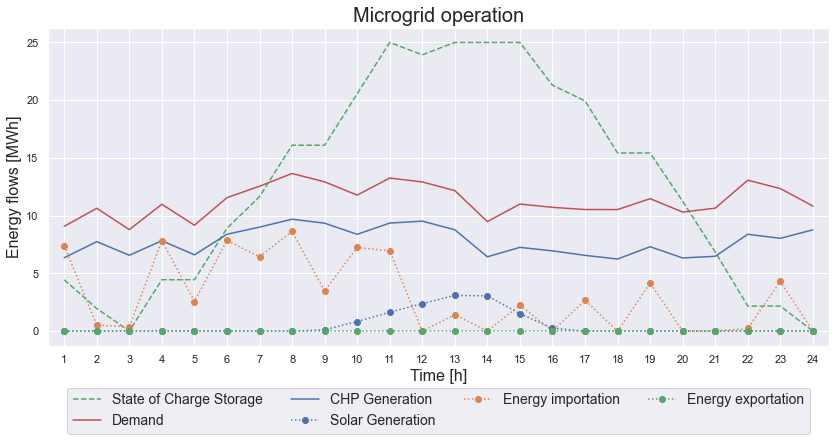

In [25]:
#Plotting results

x_time2=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
figure=plt.figure(figsize=(14,7))
plt.plot(x_time2,e.value,'g--',label='stage of charge storage')
plt.plot(x_time2,electricity_demand/1000,'r',label='demand')
plt.plot(x_time2,(elec_eff/heat_eff)*he.value,'b',label='chp generation')
plt.plot(x_time2,solar_generation*23.1,'o:',label='solar generation')
plt.plot(x_time2,P_import.value,'o:',label='Energy importation')
plt.plot(x_time2,-P_export.value,'o:',label='Energy exportation')
plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Energy flows [MWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24.5)
plt.title('Microgrid operation',fontsize=20)
labels = ["State of Charge Storage","Demand","CHP Generation","Solar Generation","Energy importation","Energy exportation"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.3),fontsize=14)
figure.subplots_adjust(bottom=0.25)


NameError: name 'df_dispersion_all' is not defined

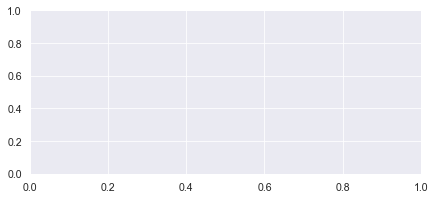

In [45]:
# Plot
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_context(context='paper', font_scale=1.2)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))

df_dispersion_all['Overall CV'].plot(ax=axes, linewidth=1, linestyle='-', marker='o', color='k', fillstyle='none')
df_dispersion_all['Overall CQV'].plot(ax=axes, linewidth=1, linestyle='--', marker='*', color='b', fillstyle='none')
axes.set_xlabel('Building No.')
axes.set_ylabel('Dispersion level of load profiles')
plt.ylim((0, 1.2))
axes.legend(ncol=1, loc='upper center',frameon=False)

fig.tight_layout()
plt.savefig('Example.png')


### Seasonal testing 

In [26]:
X=X.value # New boundary from previous sizing

In [27]:
#This functions enable to import data from a csv file into Python. 
#The function is define to import hourly data on a yearly basis
# A month column is also added, which is useful to realise seasonal studies

def readcsv(directory):
    df3=pd.read_csv(directory,header=[0], index_col=[0],nrows=24*365)
    l=[]
    for i in range (0,len(df3)):
        l.append(df3['Date'][i][:5])
    df3.insert(loc=1, column='Month',value=np.array(l))

    return(df3)

def readcsv2(directory):
    df3=pd.read_csv(directory,header=[0], index_col=[0],nrows=24*365)
    l=[]
    for i in range (0,len(df3)):
        l.append(df3['Date'][i][5:10])
    df3.insert(loc=1, column='Month',value=np.array(l))

    return(df3)

In [28]:
df_demand=readcsv('Super Parc Veolia data 2.csv')
df_demand = df_demand.iloc[::1,:]

df_price = readcsv('UK Energy prices.csv')
df_price = df_price.iloc[::1,:] # selects data with hourly frequency

df_generation = readcsv('Solar UK.csv')
df_generation = df_generation.iloc[::1,:] # selects data with hourly frequency

In [29]:
#Seasonal data computation
def seasonal_data(df,Name):
    l=[]
    lwi=[]
    lsp=[]
    lsu=[]
    lau=[]
    for i in range (1,25):
        l.append((i))
        lwi.append((df.loc[((df['Month'] >= '01-01') & (df['Month'] <= '03-31')) & (df['Time'] == i )][Name]).mean())
        lsp.append((df.loc[((df['Month'] >= '04-01') & (df['Month'] <= '06-30')) & (df['Time'] == i )][Name]).mean())
        lsu.append((df.loc[((df['Month'] >= '07-01') & (df['Month'] <= '09-30')) & (df['Time'] == i )][Name]).mean())
        lau.append((df.loc[((df['Month'] >= '10-01') & (df['Month'] <= '12-31')) & (df['Time'] == i )][Name]).mean())
    
    df1 = pd.DataFrame({"Time": l, "Winter Consumption": lwi, "Spring Consumption": lsp, "Summer Consumption": lsu, "Autumn Consumption": lau})
    return df1


In [30]:
df_seasonal_electricity=seasonal_data(df_demand,'Electricity (kWh)')
df_seasonal_indusheat=seasonal_data(df_demand,'Industrial heat (kWh)')
df_seasonal_nonindusheat=seasonal_data(df_demand,'Non industrial heat (kWh)')
df_seasonal_pricebuying=seasonal_data(df_price,'Electricity Buying')
df_seasonal_priceselling=1.39*seasonal_data(df_price,'Electricity Selling')
df_seasonal_generation=seasonal_data(df_generation,'Solar generation')

#df_seasonal_pricebuying.to_csv('Buying.csv')
#df_seasonal_priceselling.to_csv('Selling.csv')

In [31]:
# Autumn
buying_price1=df_seasonal_pricebuying['Autumn Consumption'].values
selling_price1=df_seasonal_priceselling['Autumn Consumption'].values
electricity_demand1=df_seasonal_electricity['Autumn Consumption'].values
heat_demand1=df_seasonal_indusheat['Autumn Consumption'].values
solar_generation1=df_seasonal_generation['Autumn Consumption'].values

# This step must be done 4 times, by changing the 'Autumn Consumption' in 'Winter Consumption', then 'Spring Consumption' and then 'Summer Consumption'

In [32]:
#Problem definition
import picos as pic
prob3 = pic.Problem() # initialises problem object

# energy exchange variables
P_import = pic.RealVariable('P_import',n_periods) # importing energy from the grid
P_export = pic.RealVariable('P_export',n_periods) # exporting energy from the grid
#Flow of energy towards the battery 
P_solarde = pic.RealVariable('P_solarde',n_periods) 
P_solarba = pic.RealVariable('P_solarba',n_periods) 
P_chpde = pic.RealVariable('P_chpde',n_periods) 
P_chpba = pic.RealVariable('P_chpba',n_periods)
P_battde = pic.RealVariable('P_battde',n_periods) 
e = pic.RealVariable('e',n_periods)
# Sizing Variables
# the following is not necessary, but useful when constants are vectors and not scalars
p = pic.Constant('pr',buying_price1) # [USD/kWh]
p_sell = pic.Constant('pr_s',selling_price1) # [USD/kWh]
de = pic.Constant('electricity demand',electricity_demand1/1000) # [MWh]
he = pic.Constant('heat demand',heat_demand1/1000) # [MWh]
sol = pic.Constant('sol',solar_generation1) # [kWh]



In [33]:
#Energy balance

# Electricity
prob3.add_constraint(P_chpde + P_solarde + batt_eff*P_battde + P_import + P_export  == de) 
prob3.add_constraint(P_chpde + P_chpba == (elec_eff/heat_eff)*he)
prob3.add_constraint(P_solarde + P_solarba  == X*sol )
prob3.add_constraint(P_solarde>=0)
prob3.add_constraint(P_solarba>=0)
prob3.add_constraint(P_chpde>=0)
prob3.add_constraint(P_chpba>=0)
prob3.add_constraint(P_battde>=0)
prob3.add_constraint(P_import>=0)
prob3.add_constraint(P_export<=0)
# storage capacity 
prob3.add_constraint(e <= 25)
prob3.add_constraint(0 <= e )
# integrator dynamics
prob3.add_constraint(e[0] == e_init + batt_eff*(P_solarba[0] + P_chpba[0]) - P_battde[0])
for t in range(1,n_periods):
    prob3.add_constraint(e[t] == e[t-1] + batt_eff*(P_solarba[t] + P_chpba[t]) - P_battde[t])

# constraint on final SoC        
#prob2.add_constraint(e[n_periods-1] == e_init) 

#Storage definition 
# discharge
prob3.add_constraint(P_battde <= batt_power_rating) 
# charge
prob3.add_constraint(P_solarba + P_chpba <=  batt_power_rating)



<24×1 Affine Constraint: P_solarba + P_chpba ≤ [4.68436]>

In [34]:
enrg_cost3 = (n_periods/24)*(1000*capex_solar*X/(365*lt_solar)+1000*X*opex_solar/365 + 1000*capex_chp*max(he)/(365*lt_chp)+1000*sum(he)*opex_chp/365 + 1000*max(e)*co2_batt*(n_periods/24)*co2_price + 1000*(capex_battery/lt_battery+opex_battery)*max(e)/365) +  sum(10*(p[t]+co2_grid*co2_price)*P_import[t]+10*p_sell[t]*P_export[t]+10*he[t]*(biogas_fuel/heat_eff + co2_chp*co2_price) + 10*X*sol[t]*co2_solar*co2_price  for t in range(n_periods))
prob3.set_objective('min',enrg_cost3)
solv = prob3.solve(solver='cvxopt')

<ipython-input-34-d9a9ad3a6fdd>:1: DeprecationWarning: Expression.__gt__ is deprecated: PICOS treats all inequalities as non-strict. Using the strict inequality comparison operators may lead to unexpected results when dealing with integer problems.
  enrg_cost3 = (n_periods/24)*(1000*capex_solar*X/(365*lt_solar)+1000*X*opex_solar/365 + 1000*capex_chp*max(he)/(365*lt_chp)+1000*sum(he)*opex_chp/365 + 1000*max(e)*co2_batt*(n_periods/24)*co2_price + 1000*(capex_battery/lt_battery+opex_battery)*max(e)/365) +  sum(10*(p[t]+co2_grid*co2_price)*P_import[t]+10*p_sell[t]*P_export[t]+10*he[t]*(biogas_fuel/heat_eff + co2_chp*co2_price) + 10*X*sol[t]*co2_solar*co2_price  for t in range(n_periods))


In [35]:
total_elec = sum(electricity_demand) #kWh
total_heat = sum(heat_demand)
total_imports= sum(P_import)
total_exports = sum(P_export)
emissions=sum(1000*co2_grid*P_import[t]+1000*he[t]/heat_eff*co2_chp +1000*X*sol[t]*co2_solar  for t in range(n_periods))+co2_batt*max(e.value)*1000
energy_intensity=emissions/(total_elec+total_heat)
print(enrg_cost3)
cost_kWh=enrg_cost3.value/(total_elec+total_heat)
print('Completed. Status: ' + prob3.status)
print ('X:',X, 'MW' )
print('Grid Share:',total_imports*1000/total_elec*100,'%')
print('Total imports:',total_imports,'MWh')
excess_generation=total_exports*1000/(total_heat+total_elec)*100
print('Excess generation',excess_generation)
print('Max Charing/Discharging capacity',max(P_battde.value),'MWh')
print('Energy cost: '+str(enrg_cost2.value),'USD')
print('Cost/kWh',cost_kWh,'USD')
print('Battery capacity',max(e.value),'MWh')
print(energy_intensity)
#pd.DataFrame(P_import.value).to_csv('Imports.csv')
#pd.DataFrame(P_export.value).to_csv('Exports.csv')

32649.128886304123
Completed. Status: optimal
X: 23.106473778976525 MW
Grid Share: 9.603938783861429 %
Total imports: 25.971247360649222 MWh
Excess generation -5.226133230935795
Max Charing/Discharging capacity 4.684362669310053 MWh
Energy cost: 42732.12484056094 USD
Cost/kWh 0.06361331015810295 USD
Battery capacity 24.99999999996154 MWh
97.77026998534174


In [49]:
type(e)

picos.expressions.variables.RealVariable

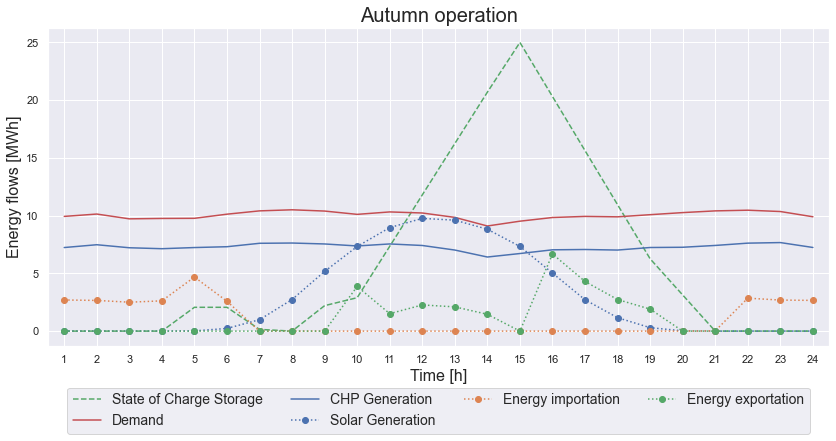

In [36]:
figure=plt.figure(figsize=(14,7))
plt.plot(x_time2,e.value,'g--',label='stage of charge storage')
plt.plot(x_time2,electricity_demand1/1000,'r',label='demand')
plt.plot(x_time2,(elec_eff/heat_eff)*he.value,'b',label='chp generation')
plt.plot(x_time2,solar_generation1*23.1,'o:',label='solar generation')
plt.plot(x_time2,P_import.value,'o:',label='Energy importation')
plt.plot(x_time2,-P_export.value,'o:',label='Energy exportation')
plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Energy flows [MWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24.5)

plt.title('Autumn operation',fontsize=20)
labels = ["State of Charge Storage","Demand","CHP Generation","Solar Generation","Energy importation","Energy exportation"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.3),fontsize=14)
figure.subplots_adjust(bottom=0.25)


## Seasonal data analysis: solar generation, electricity, heat and cooling demand 

In [37]:
solar_generation1=df_seasonal_generation['Summer Consumption'].values
solar_generation2=df_seasonal_generation['Spring Consumption'].values
solar_generation3=df_seasonal_generation['Winter Consumption'].values
solar_generation4=df_seasonal_generation['Autumn Consumption'].values
#df_seasonal_generation.to_csv('Solargenrataion.csv')

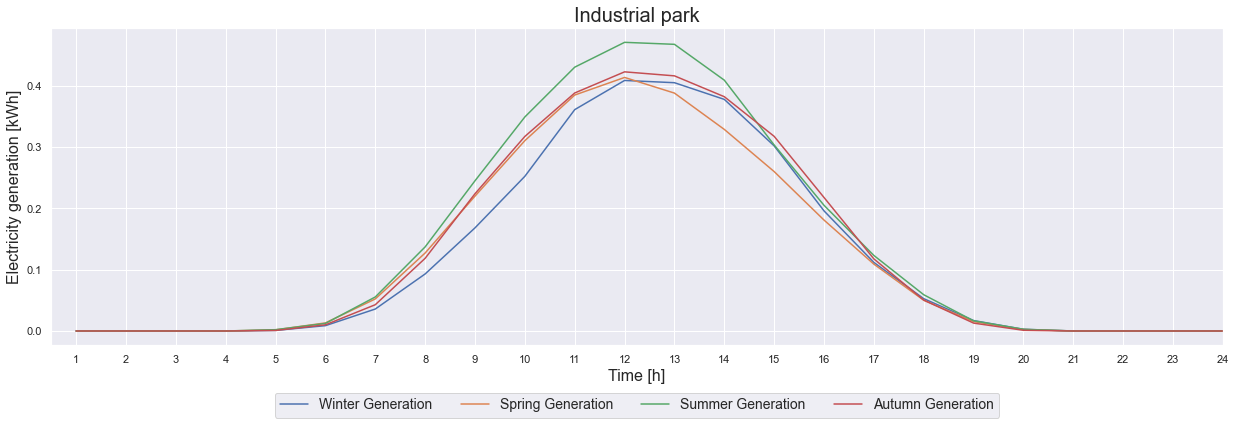

In [38]:
figure=plt.figure(figsize=(21,7))
plt.plot(x_time2,solar_generation1)
plt.plot(x_time2,solar_generation2)
plt.plot(x_time2,solar_generation3)
plt.plot(x_time2,solar_generation4)
plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Electricity generation [kWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24)

plt.title('Industrial park',fontsize=20)
labels = ["Winter Generation", "Spring Generation", "Summer Generation","Autumn Generation"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.25),fontsize=14)
figure.subplots_adjust(bottom=0.25)

In [39]:
electricity_demand1=df_seasonal_electricity['Winter Consumption'].values
heat_demand1=df_seasonal_indusheat['Winter Consumption'].values
electricity_demand2=df_seasonal_electricity['Spring Consumption'].values
heat_demand2=df_seasonal_indusheat['Spring Consumption'].values
electricity_demand3=df_seasonal_electricity['Summer Consumption'].values
heat_demand3=df_seasonal_indusheat['Summer Consumption'].values
electricity_demand4=df_seasonal_electricity['Autumn Consumption'].values
heat_demand4=df_seasonal_indusheat['Autumn Consumption'].values


nonheat_demand1=df_seasonal_nonindusheat['Winter Consumption'].values
nonheat_demand2=df_seasonal_nonindusheat['Spring Consumption'].values
nonheat_demand3=df_seasonal_nonindusheat['Summer Consumption'].values
nonheat_demand4=df_seasonal_nonindusheat['Autumn Consumption'].values


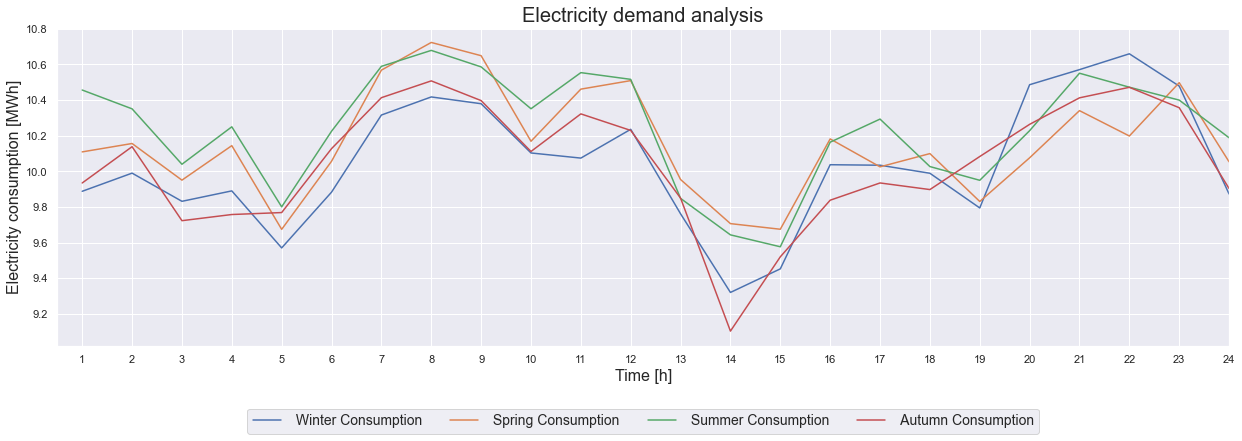

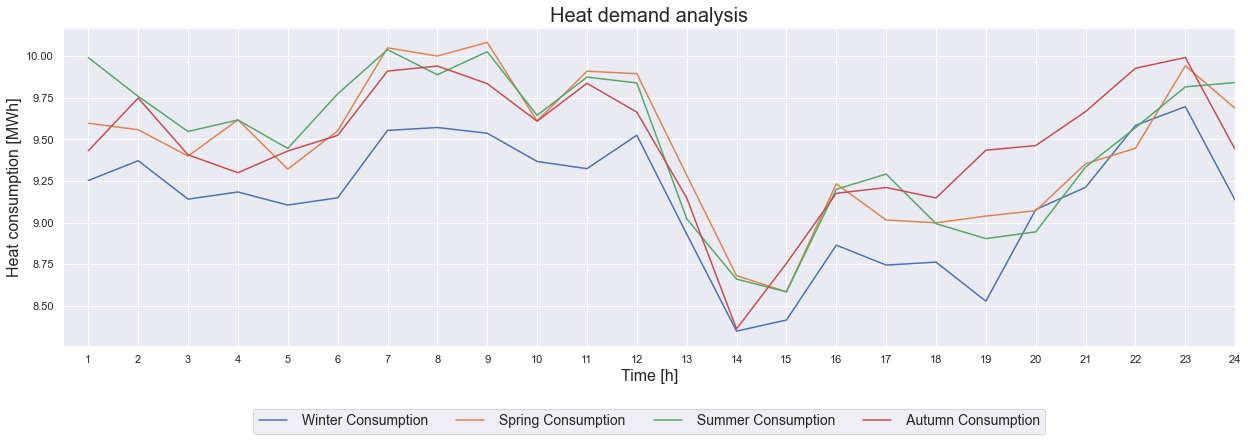

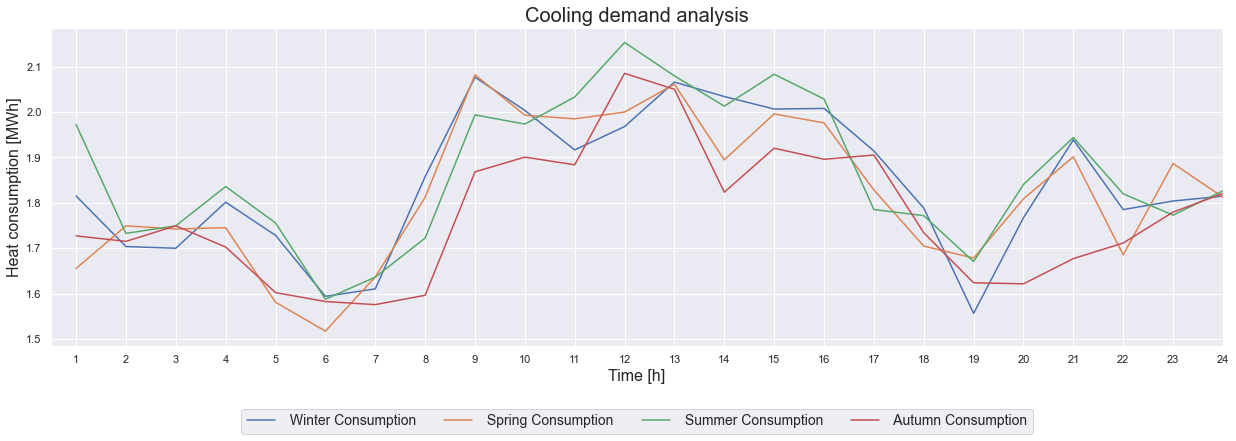

In [40]:
figure=plt.figure(figsize=(21,7))
plt.plot(x_time2,electricity_demand1/1000)
plt.plot(x_time2,electricity_demand2/1000)
plt.plot(x_time2,electricity_demand3/1000)
plt.plot(x_time2,electricity_demand4/1000)

plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Electricity consumption [MWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24)

plt.title('Electricity demand analysis',fontsize=20)
labels = [" Winter Consumption", " Spring Consumption", " Summer Consumption"," Autumn Consumption"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.3),fontsize=14)
figure.subplots_adjust(bottom=0.25)

figure=plt.figure(figsize=(21,7))
plt.plot(x_time2,heat_demand1/1000)
plt.plot(x_time2,heat_demand2/1000)
plt.plot(x_time2,heat_demand3/1000)
plt.plot(x_time2,heat_demand4/1000)

plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Heat consumption [MWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24)
plt.title('Heat demand analysis',fontsize=20)
labels = [" Winter Consumption", " Spring Consumption", " Summer Consumption"," Autumn Consumption"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.3),fontsize=14)
figure.subplots_adjust(bottom=0.25)

figure=plt.figure(figsize=(21,7))
plt.plot(x_time2,nonheat_demand1/1000)
plt.plot(x_time2,nonheat_demand2/1000)
plt.plot(x_time2,nonheat_demand3/1000)
plt.plot(x_time2,nonheat_demand4/1000)

plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Heat consumption [MWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24)
plt.title('Cooling demand analysis',fontsize=20)
labels = [" Winter Consumption", " Spring Consumption", " Summer Consumption"," Autumn Consumption"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.3),fontsize=14)
figure.subplots_adjust(bottom=0.25)

In [41]:
diff1= electricity_demand1 - heat_demand1
diff2= electricity_demand2 - heat_demand2
diff3= electricity_demand3 - heat_demand3
diff4= electricity_demand4 - heat_demand4

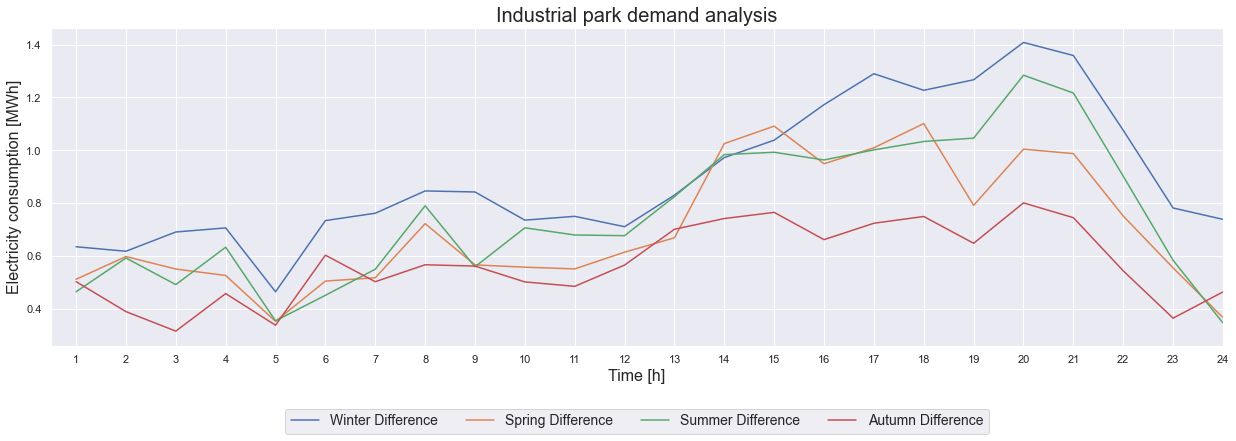

In [42]:
figure=plt.figure(figsize=(21,7))
plt.plot(x_time2,diff1/1000)
plt.plot(x_time2,diff2/1000)
plt.plot(x_time2,diff3/1000)
plt.plot(x_time2,diff4/1000)


plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Electricity consumption [MWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24)

plt.title('Industrial park demand analysis',fontsize=20)
labels = ["Winter Difference", "Spring Difference","Summer Difference","Autumn Difference"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.3),fontsize=14)
figure.subplots_adjust(bottom=0.25)

In [43]:
buying_price1=df_seasonal_pricebuying['Winter Consumption'].values
selling_price1=df_seasonal_priceselling['Winter Consumption'].values
buying_price2=df_seasonal_pricebuying['Spring Consumption'].values
selling_price2=df_seasonal_priceselling['Spring Consumption'].values
buying_price3=df_seasonal_pricebuying['Summer Consumption'].values
selling_price3=df_seasonal_priceselling['Summer Consumption'].values
buying_price4=df_seasonal_pricebuying['Autumn Consumption'].values
selling_price4=df_seasonal_priceselling['Autumn Consumption'].values

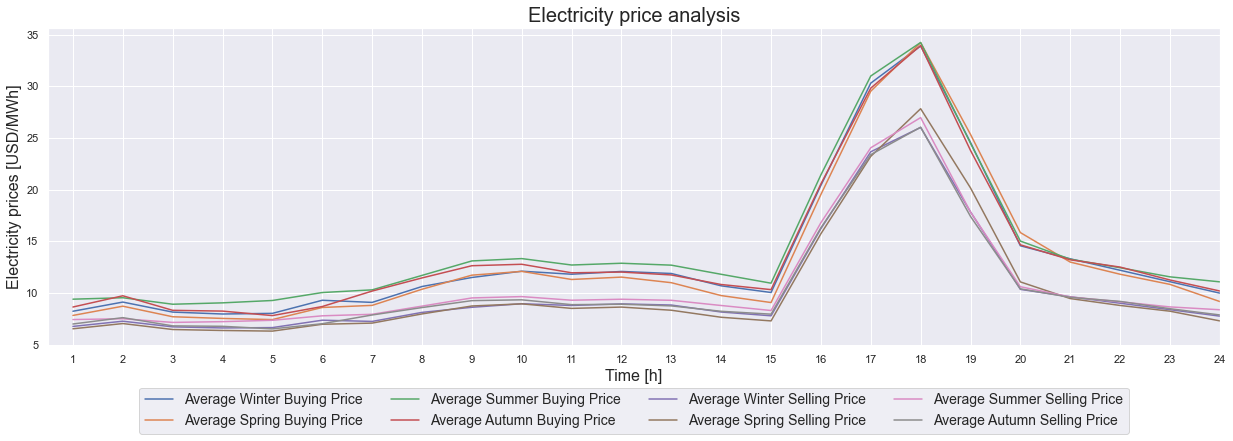

In [44]:
figure=plt.figure(figsize=(21,7))
plt.plot(x_time2,1.39*buying_price1)
plt.plot(x_time2,1.39*buying_price2)
plt.plot(x_time2,1.39*buying_price3)
plt.plot(x_time2,1.39*buying_price4)
plt.plot(x_time2,1.39*selling_price1)
plt.plot(x_time2,1.39*selling_price2)
plt.plot(x_time2,1.39*selling_price3)
plt.plot(x_time2,1.39*selling_price4)
plt.xlabel('Time [h]',loc="center",fontsize=16)
plt.ylabel('Electricity prices [USD/MWh]',loc="center",fontsize=16)
plt.xticks(np.arange(0, 25, 1))
plt.xlim(0.5,24)

plt.title('Electricity price analysis',fontsize=20)
labels = ["Average Winter Buying Price", "Average Spring Buying Price", "Average Summer Buying Price","Average Autumn Buying Price", "Average Winter Selling Price", "Average Spring Selling Price", "Average Summer Selling Price","Average Autumn Selling Price"]
plt.legend(labels,ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.3),fontsize=14)
figure.subplots_adjust(bottom=0.25)